<a href="https://colab.research.google.com/github/oluseyedev/oluseyedev/blob/main/Dat7015_Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install -q keras

In [ ]:
import keras

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
# Property used to format output tables better
spark

In [ ]:
!pip install pandas scikit-learn

In [ ]:
# import libraries
!pip install matplotlib-venn
from sklearn.impute import SimpleImputer
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import style
style.use('ggplot')
from pyspark.ml.stat import Correlation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import pyspark
from pyspark.sql.types import *

In [ ]:
!pip install pyexcel pyexcel-ods pyexcel-ods3 pyexcel-odsr pyexcel-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.7 MB/s eta 0:00:00
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160673 sha256=7cf6c6c48523844dea8f1099e6d1728d81df8a9de458c188f97afab551c39395
  Stored in directory: /root/.cache/pip/wheels/c8/2e/95/90d94fe33903786937f3b8c33dd88807f792359c6424b40469
Successfully built odfpy


In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName('crime_analysis').getOrCreate()

In [ ]:
# Load excel datasets into pandas dataframes
ref = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Big Data Assignment2/Assignment2/excel file/reccrime-offence-ref.xlsx')
tables = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Big Data Assignment2/Assignment2/excel file/prc-pfa-mar2013-onwards-tables.xlsx', sheet_name=None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Select the table of interest and create a dataframe
yr_2018_19 = tables['2018-19']
yr_2019_20 = tables['2019-20']
yr_2020_21 = tables['2020-21']
yr_2021_22 = tables['2021-22']
yr_2022_23 = tables['2022-23']
yr_2023_24 = tables['2023-24']

In [ ]:
# create a schema for the PySpark DataFrame
schema = StructType([
StructField("Offence Code", StringType(), True),
StructField("Offence description", StringType(), True),
StructField("Old PRC offence group", StringType(), True),
StructField("Old offence sub-group", StringType(), True),
StructField("New ONS offence group", StringType(), True),
StructField("New ONS sub-offence group", StringType(), True),
])



In [ ]:
offence_ref = ref

In [ ]:
ref = ref.toPandas()
# create a PySpark DataFrame from the pandas DataFrame using the schema
ref = spark.createDataFrame(ref, schema=schema)
# show the content of the ref DataFrame
ref.show()

+--------------+--------------------+---------------------+---------------------+---------------------+-------------------------+
|  Offence Code| Offence description|Old PRC offence group|Old offence sub-group|New ONS offence group|New ONS sub-offence group|
+--------------+--------------------+---------------------+---------------------+---------------------+-------------------------+
|             1|              Murder| Violence against ...| Violence against ...| Violence against ...|                 Homicide|
|     1/4.1/4.2|            Homicide| Violence against ...| Violence against ...| Violence against ...|                 Homicide|
|1/4.1/4.2/4.10|            Homicide| Violence against ...| Violence against ...| Violence against ...|                 Homicide|
|           104|Assault without i...| Violence against ...| Violence against ...| Violence against ...|     Violence without ...|
|          105A|Assault without i...| Violence against ...| Violence against ...| Violence

In [ ]:
# Convert table file  and offence_ref_file to pyspark dataframe
df_2018_19 = spark.createDataFrame(yr_2018_19)
df_2019_20 = spark.createDataFrame(yr_2019_20)
df_2020_21 = spark.createDataFrame(yr_2020_21)
df_2021_22 = spark.createDataFrame(yr_2021_22)
df_2022_23 = spark.createDataFrame(yr_2022_23)
df_2023_24 = spark.createDataFrame(yr_2023_24)

/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
# Create temporary views of the dataframes
df_2018_19.createOrReplaceTempView('df_2018_19')
df_2019_20.createOrReplaceTempView('df_2019_20')
df_2020_21.createOrReplaceTempView('df_2020_21')
df_2021_22.createOrReplaceTempView('df_2021_22')
df_2022_23.createOrReplaceTempView('df_2022_23')
df_2023_24.createOrReplaceTempView('df_2023_24')




In [ ]:
ref.head()

Row(Offence Code='1', Offence description='Murder', Old PRC offence group='Violence against the person', Old offence sub-group='Violence against the person - with injury', New ONS offence group='Violence against the person', New ONS sub-offence group='Homicide')

In [ ]:
# Write sql queries to join tables
query_1 = """
                SELECT * FROM df_2018_19
                UNION
                SELECT * FROM df_2019_20
                UNION
                SELECT * FROM df_2020_21
                UNION
                SELECT * FROM df_2021_22
                UNION
                SELECT * FROM df_2022_23
                UNION
                SELECT * FROM df_2023_24
"""


In [ ]:
# Load query and return dataframe
offence_df = spark.sql(query_1)

In [ ]:
print(offence_df.count())

124193


In [ ]:
print(offence_ref.count())

188


In [ ]:
# Rename col to remove white space
rename_cols = {
                'Financial Year': 'Financial_Year',
                'Financial Quarter':'Financial_Quarter',
                'Force Name':'Force_Name',
                'Offence Description':'Offence_Description',
                'Offence Group':'Offence_Group',
                'Offence Subgroup':'Offence_Subgroup',
                'Offence Code':'Offence_Code',
                'Number of Offences':'Number_of_Offences',
                'Old PRC offence group': 'Old_PRC_offence_group',
                'Old offence sub-group': 'Old_offence_sub-group',
                'New ONS offence group': 'New_ONS_offence_group',
                'New ONS sub-offence group': 'New_ONS_sub_offence_group'
}


In [ ]:
print(offence_df.count())

124193


In [ ]:
offence_df.head()

Row(Financial Year='2018/19', Financial Quarter=1, Force Name='Cheshire', Offence Description='Wildlife', Offence Group='Miscellaneous crimes against society', Offence Subgroup='Miscellaneous crimes against society', Offence Code='96', Number of Offences=1)

In [ ]:
offence_df.drop('is_null')

Financial Year,Financial Quarter,Force Name,Offence Description,Offence Group,Offence Subgroup,Offence Code,Number of Offences
2018/19,1,Cheshire,Wildlife,Miscellaneous cri...,Miscellaneous cri...,96,1
2018/19,1,Cumbria,Possession of con...,Drug offences,Possession of drugs,92E,122
2018/19,1,Devon and Cornwall,Sexual assault on...,Sexual offences,Other sexual offe...,20A,286
2018/19,1,Durham,Endangering life,Violence against ...,Violence with injury,5E,1
2018/19,1,Dyfed-Powys,Possession of art...,Possession of wea...,Possession of wea...,10D,32
2018/19,1,Essex,Bigamy,Miscellaneous cri...,Miscellaneous cri...,26,0
2018/19,1,Hampshire,Abuse of children...,Sexual offences,Other sexual offe...,71,7
2018/19,1,Hertfordshire,Attempted murder,Violence against ...,Violence with injury,2,2
2018/19,1,Hertfordshire,Burglary Residential,Theft offences,Domestic burglary,28E,868
2018/19,1,Hertfordshire,Conspiracy to murder,Violence against ...,Violence without ...,3A,1


In [ ]:

# Loops through rename_cols and removes white space
for old_name, new_name in rename_cols.items():
    offence_df = offence_df.withColumnRenamed(old_name, new_name)
    offence_ref = ref.withColumnRenamed(old_name, new_name)
print(offence_ref.count())
print(offence_df.count())

198
124193


In [ ]:
# Drop duplicates in offence_ref
offence_ref = offence_ref.dropDuplicates()



In [ ]:
print(offence_ref.count())

188


In [ ]:
offence_ref = offence_ref.withColumnRenamed('Offence Code', 'Offence_Code')

In [213]:
# register the DataFrame as a temporary view
offence_ref.createOrReplaceTempView('offence_ref')

In [251]:
# Create temporary views of the dataframes
offence_df.createOrReplaceTempView('offence_df')
offence_ref.createOrReplaceTempView('offence_ref')



In [252]:
offence_df.createOrReplaceTempView('offence_df')
ref.createOrReplaceTempView('offence_ref')

In [254]:
# Write sql query to join tables
query_2 = """
SELECT offence_df.*,
offence_ref.`New ONS offence group`,
offence_ref.`New ONS sub-offence group`,
FROM offence_df
INNER JOIN offence_ref
ON offence_df.Offence_Code = offence_ref.Offence_Code;
"""




In [223]:
offence_df.head()

Row(Financial_Year='2018/19', Financial_Quarter=1, Force_Name='Cheshire', Offence_Description='Wildlife', Offence_Group='Miscellaneous crimes against society', Offence_Subgroup='Miscellaneous crimes against society', Offence_Code='96', Number_of_Offences=1)

In [224]:
offence_ref.head()

Row(Offence_Code='90', Offence description='Other knives offences', Old PRC offence group='Other miscellaneous offences', Old offence sub-group='NaN', New ONS offence group='Possession of weapons offences', New_ONS_sub_offence_group='Possession of weapons offences')

In [225]:
# show the values of the Offence_Code column in both tables
offence_df.select('Offence_Code').show()
offence_ref.select('Offence_Code').show()

+------------+
|Offence_Code|
+------------+
|          96|
|         92E|
|         20A|
|          5E|
|         10D|
|          26|
|          71|
|           2|
|         28E|
|          3A|
|         58D|
|          9A|
|          61|
|         58B|
|         88A|
|          60|
|         10B|
|         92D|
|          73|
|         126|
+------------+
only showing top 20 rows

+------------+
|Offence_Code|
+------------+
|          90|
|         92A|
|         58F|
|          33|
|         8Q*|
|         10B|
|          8G|
|          5D|
|          23|
|          84|
|         58B|
|          22|
|          46|
|           7|
|          8B|
|         19C|
|         58A|
|          60|
|          83|
|         88B|
+------------+
only showing top 20 rows



In [226]:
import pyspark.sql.functions as F
# convert the values of the Offence_Code column to string and uppercase in both tables
offence_df = offence_df.withColumn('Offence_Code', F.upper(F.col('Offence_Code').cast('string')))
offence_ref = offence_ref.withColumn('Offence_Code', F.upper(F.col('Offence_Code').cast('string')))
# join the tables using an INNER JOIN
joined_df = offence_df.join(offence_ref, 'Offence_Code', 'inner')
# check the number of rows after joining
rows = joined_df.count()
print(f'The number of rows after joining is: {rows}')

The number of rows after joining is: 107184


In [235]:
query_2=rows

In [229]:
# check the number of rows using the count function
rows = joined_df.count()
print(f'The number of rows after joining is: {rows}')

The number of rows after joining is: 107184


In [228]:
# check the number of columns using the len function on the columns attribute
cols = len(joined_df.columns)
# print the results

print(f'The number of columns after joining is: {cols}')

The number of columns after joining is: 13


In [232]:
# join the tables using a LEFT JOIN
joined_df = offence_df.join(offence_ref, 'Offence_Code', 'left')
# check the number of rows after joining
rows = joined_df.count()
print(f'The number of rows after joining is: {rows}')

The number of rows after joining is: 124193


In [240]:
print(type(query_2))

<class 'int'>


In [242]:
# convert the query_2 variable to a string
query_2 = str(query_2)


In [246]:
# Write sql query to join tables
query_2 = """
SELECT offence_df.*,
offence_ref.`New ONS offence group`,
offence_ref.`New ONS sub-offence group`
FROM offence_df
INNER JOIN offence_ref
ON offence_df.Offence_Code = offence_ref.Offence_Code;
"""

In [250]:
# create or replace a temporary view named offence_final
offence_final_df.createOrReplaceTempView("offence_final")
# create or replace a global temporary view named offence_final
offence_final_df.createOrReplaceGlobalTempView("offence_final")

NameError: name 'offence_final_df' is not defined

In [249]:
#  Create offence_final with query
offence_final = spark.sql(query_2)

AnalysisException: Table or view not found: offence_final; line 1 pos 14;
'Project [*]
+- 'UnresolvedRelation [offence_final], [], false


In [231]:
print(offence_final.count())

0


In [ ]:
# Print schema
offence_final.printSchema()

root
 |-- Financial_Year: integer (nullable = true)
 |-- Financial_Quarter: long (nullable = true)
 |-- Force_Name: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Offence_Group: string (nullable = true)
 |-- Offence_Subgroup: string (nullable = true)
 |-- Offence_Code: string (nullable = true)
 |-- Number_of_Offences: long (nullable = true)
 |-- New_ONS_offence_group: string (nullable = true)
 |-- New_ONS_sub_offence_group: string (nullable = true)



In [ ]:
# Get year from financial year column
offence_final = offence_final.withColumn('Financial_Year', substring('Financial_Year',  1,  4))

# Convert Financial year column to int
offence_final = offence_final.withColumn('Financial_Year',  offence_final.Financial_Year.cast('int'))

In [ ]:
offence_final.head(5)

[]

In [ ]:
# Check to confirm change in data type
offence_final.printSchema()

root
 |-- Financial_Year: integer (nullable = true)
 |-- Financial_Quarter: long (nullable = true)
 |-- Force_Name: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Offence_Group: string (nullable = true)
 |-- Offence_Subgroup: string (nullable = true)
 |-- Offence_Code: string (nullable = true)
 |-- Number_of_Offences: long (nullable = true)
 |-- New_ONS_offence_group: string (nullable = true)
 |-- New_ONS_sub_offence_group: string (nullable = true)



In [ ]:
# check the number of rows in the DataFrame
print(offence_final.count())

0


## Summary Statisitics

In [ ]:
# Get the total number of offences in the 6 years dataset
totalsum = offence_final.agg(sum('Number_of_Offences')).collect()[0][0]
print(f'The total sum of Number of offences from 2019-2023 is: {np.round(totalsum, 2)}')

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [ ]:
# Descriptive statistics of  Numeric Column
offence_final.describe(['Number_of_Offences']).show()

+-------+------------------+
|summary|Number_of_Offences|
+-------+------------------+
|  count|             86768|
|   mean|218.72708832749402|
| stddev| 884.6202960002709|
|    min|                 0|
|    max|             29480|
+-------+------------------+



In [ ]:
# Correlation betwen financial year and number of offences
yr_corr_offence = offence_final.corr('Financial_Year', 'Number_of_Offences')

print(f'The correlation between Financial Year and Number of offences is: {yr_corr_offence:.4f}')

# Correlation betwen financial year and number of offences
qt_corr_offence = offence_final.corr('Financial_Quarter', 'Number_of_Offences')

print(f'The correlation between Financial Year and Number of offences is: {qt_corr_offence:.4f}')

The correlation between Financial Year and Number of offences is: 0.0098


The correlation between Financial Year and Number of offences is: -0.0053


In [ ]:
# Covariance betwen financial year and number of offences
yr_corr_offence = offence_final.cov('Financial_Year', 'Number_of_Offences')

print(f'The covariance between Financial Year and Number of offences is: {yr_corr_offence:.4f}')

# Covariance betwen financial year and number of offences
qt_corr_offence = offence_final.cov('Financial_Quarter', 'Number_of_Offences')

print(f'The covariance between Financial Year and Number of offences is: {qt_corr_offence:.4f}')

The covariance between Financial Year and Number of offences is: 10.6975


The covariance between Financial Year and Number of offences is: -5.3606


In [ ]:
# check for skewness of Number of Offences
skewness_num_of_offences = offence_final.select(skewness('Number_of_Offences')).collect()[0][0]

print(f'The skewness is: {skewness_num_of_offences: .2f}')

The skewness is:  12.29


## Hypothesis Testing

#### Research questions

 -  Has the overall number of offenses changed significantly over time?
    *   Null hypothesis (H0): The mean number of offenses has not changed significantly over time.
    *    Alternate hypothesis (Ha): The mean number of offenses has changed significantly over time.
    *  Test: ANOVA

 -  Do certain financial quarters exhibit consistently higher or lower offense rates?
    *  H0: There is no significant difference in offense rates between financial quarters.
    *  Ha: There is a significant difference in offense rates between financial quarters.
    * Test: ANOVA comparing offense rates across quarters.

 -  Does the type of offense tend to change based on the financial quarter?
    * H0: There is no association between offense type and financial quarter.
    * Ha: There is an association between offense type and financial quarter.
    * Test: Chi-square test of independence.

-  Are certain offense groups or subgroups more likely to occur in specific police force jurisdictions?
    * H0: The distribution of offense groups is the same across different police force jurisdictions.
    * Ha: The distribution of offense groups is different across different police force jurisdictions.
    * Test: Chi-square test of independence.

    **NOTE:  Let our signifiance level (alpha)  be 0.1**

In [ ]:
 # Does the type of offense tend to change based on the financial quarter?
sample_offence = offence_final.select('Financial_Year', 'Financial_Quarter', 'Force_Name',
                                      'New_ONS_offence_group', 'Number_of_Offences').sample(False, 0.50, 42).toPandas()

In [ ]:
# Hypothesis 1
desc_1 = """ -  Has the overall number of offenses changed significantly over time?
    *   Null hypothesis (H0): The mean number of offenses has not changed significantly over time.
    *    Alternate hypothesis (Ha): The mean number of offenses has changed significantly over time.
    *  Test: ANOVA"""

# ANOVA TESTING
val = pg.anova(data=sample_offence,
         dv='Number_of_Offences',
         between='Financial_Year')

# Displays outputs
display(desc_1)
display(val)
display('Since our pvalue is less than our siginifiance level *0.1*, we reject the null hypothesis.')
display('At least two Financial Years have a significantly different number of offences')

' -  Has the overall number of offenses changed significantly over time?\n    *   Null hypothesis (H0): The mean number of offenses has not changed significantly over time.\n    *    Alternate hypothesis (Ha): The mean number of offenses has changed significantly over time.\n    *  Test: ANOVA'

,Source,ddof1,ddof2,F,p-unc,np2
0,Financial_Year,4,43493,4.111265,0.00248,0.000378


'Since our pvalue is less than our siginifiance level *0.1*, we reject the null hypothesis.'

'At least two Financial Years have a significantly different number of offences'

In [ ]:
# Hypothesis_2
desc_3 = """  -  Do certain financial quarters exhibit consistently higher or lower offense rates?
    *  H0: There is no significant difference in offense rates between financial quarters.
    *  Ha: There is a significant difference in offense rates between financial quarters.
    * Test: ANOVA comparing offense rates across quarters."""

# ANOVA TESTING
val_1 = pg.anova(data=sample_offence,
         dv='Number_of_Offences',
         between='Financial_Quarter')

# Display outputs
display(desc_3)
display(val_1)
display('Since our pvalue is less than our siginifiance level *0.1*, we reject the null hypothesis.')
display('At least two Financial Quarters have a significantly different number of offences')

'  -  Do certain financial quarters exhibit consistently higher or lower offense rates?\n    *  H0: There is no significant difference in offense rates between financial quarters.\n    *  Ha: There is a significant difference in offense rates between financial quarters.\n    * Test: ANOVA comparing offense rates across quarters.'

,Source,ddof1,ddof2,F,p-unc,np2
0,Financial_Quarter,3,43494,0.448627,0.718269,0.000031


'Since our pvalue is less than our siginifiance level *0.1*, we reject the null hypothesis.'

'At least two Financial Quarters have a significantly different number of offences'

In [ ]:
# Hypothesis_3
desc_5 = """ -  Does the type of offense tend to change based on the financial quarter?
    * H0: There is no association between offense type and financial quarter.
    * Ha: There is an association between offense type and financial quarter.
    * Test: Chi-square test of independence."""

#  Perfrom chisquare_test of independence
expected, observed, stats = pg.chi2_independence(data=sample_offence, x='New_ONS_offence_group', y='Financial_Quarter')

# Displays output
display(desc_5)
display(stats)
display('Since our pvalue is greater than our significance level, we fail to reject the null hypothesis')

' -  Does the type of offense tend to change based on the financial quarter?\n    * H0: There is no association between offense type and financial quarter.\n    * Ha: There is an association between offense type and financial quarter.\n    * Test: Chi-square test of independence.'

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,5.630499,24.0,0.999961,0.006569,0.088272
1,cressie-read,0.666667,5.632681,24.0,0.999960,0.006570,0.088289
2,log-likelihood,0.000000,5.637248,24.0,0.999960,0.006573,0.088325
3,freeman-tukey,-0.500000,5.640850,24.0,0.999960,0.006575,0.088354
4,mod-log-likelihood,-1.000000,5.644605,24.0,0.999960,0.006577,0.088383
5,neyman,-2.000000,5.652573,24.0,0.999959,0.006582,0.088446


'Since our pvalue is greater than our significance level, we fail to reject the null hypothesis'

In [ ]:
# Hypothesis_4
desc_6 = """-  Are certain offense groups or subgroups more likely to occur in specific police force jurisdictions?
    * H0: The distribution of offense groups is the same across different police force jurisdictions.
    * Ha: The distribution of offense groups is different across different police force jurisdictions.
    * Test: Chi-square test of independence."""

#  Perfrom chisquare_test of independence
expected, observed, stats = pg.chi2_independence(data=sample_offence, x='New_ONS_offence_group', y='Force_Name')

# Displays output
display(desc_6)
display(stats)
display('Since our pvalue is greater than our significance level, we fail to reject the null hypothesis')

'-  Are certain offense groups or subgroups more likely to occur in specific police force jurisdictions?\n    * H0: The distribution of offense groups is the same across different police force jurisdictions.\n    * Ha: The distribution of offense groups is different across different police force jurisdictions.\n    * Test: Chi-square test of independence.'

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,143.927324,344.0,1.0,0.020337,0.169615
1,cressie-read,0.666667,144.100387,344.0,1.0,0.020349,0.169817
2,log-likelihood,0.000000,144.677354,344.0,1.0,0.020390,0.170493
3,freeman-tukey,-0.500000,145.321126,344.0,1.0,0.020435,0.171249
4,mod-log-likelihood,-1.000000,146.156627,344.0,1.0,0.020494,0.172233
5,neyman,-2.000000,148.454243,344.0,1.0,0.020655,0.174955


'Since our pvalue is greater than our significance level, we fail to reject the null hypothesis'

## Data Visualization

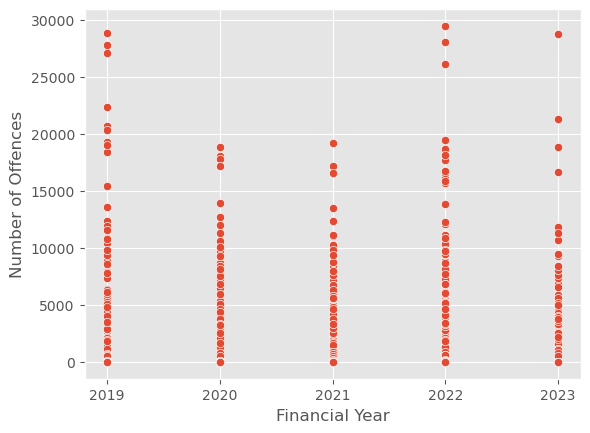

In [ ]:
# Sample target columns from dataframe
sct = offence_final.select('Financial_Year', 'Number_of_Offences').sample(False, 0.50, 42).toPandas()

# Scatter plot to check for relationship between Financial year and Number of Offences
sns.scatterplot(data=sct, x='Financial_Year', y='Number_of_Offences').set(xlabel='Financial Year',
                                                                                    ylabel='Number of Offences',
                                                                          xticks=[2019, 2020, 2021, 2022, 2023])

# Show plot
plt.show()

Text(0.5, 0, 'Number of offences')

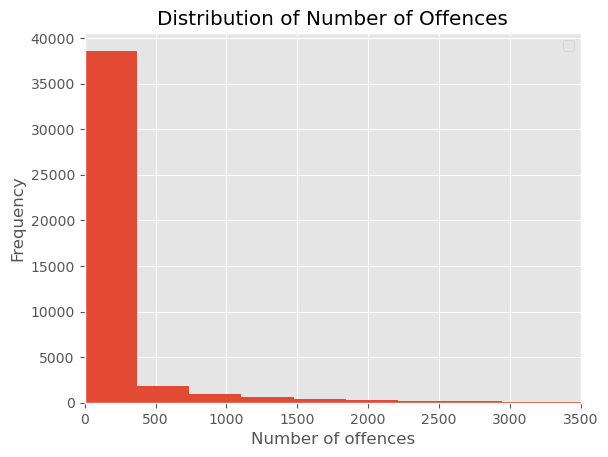

In [ ]:
# Gets sample from target column and converts to pandas
num_off_hst = offence_final.select('Number_of_Offences').sample(False, 0.50, 42).toPandas()
# Plot Distribution
num_off_hst.plot(kind='hist', bins=80)
plt.title('Distribution of Number of Offences')
plt.xlim(0, 3500)
plt.legend('')
plt.xlabel('Number of offences')

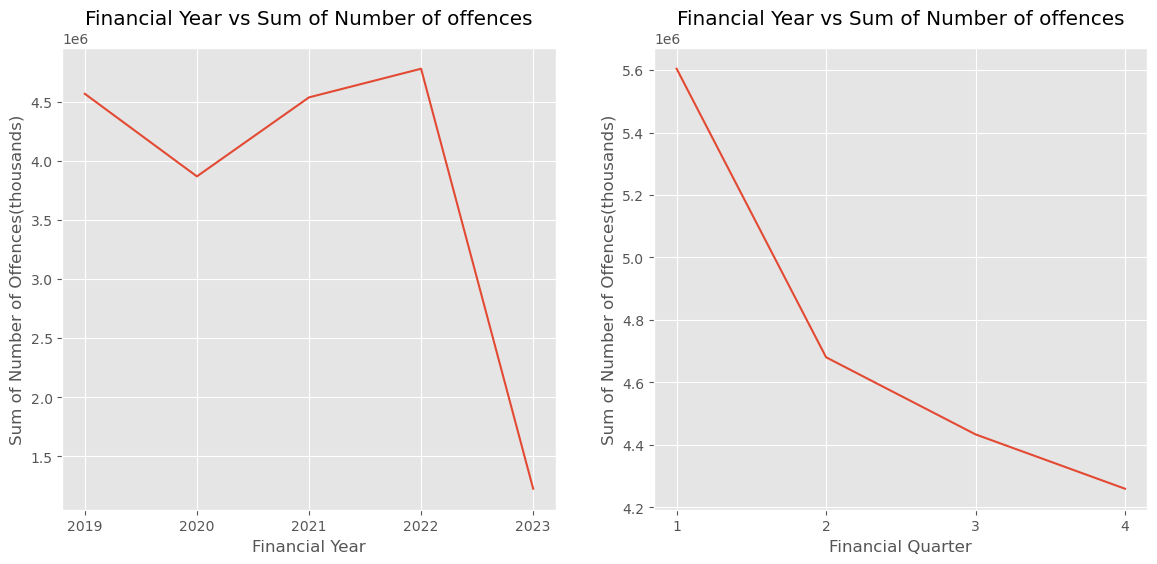

In [ ]:
# Set the figure size for plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Group data by financial year and find the sum of each year
trends_1 = offence_final.groupBy('Financial_Year').sum('Number_of_Offences').toPandas()

# Group data by financial quarter and find the sum of each offences
trends_2 = offence_final.groupBy('Financial_Quarter').sum('Number_of_Offences').toPandas()

# Plot Trends_1
sns.lineplot(data=trends_1,  x='Financial_Year', y='sum(Number_of_Offences)',
                                                                                    ax=ax[0]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Year',
                                                                                    ylabel='Sum of Number of Offences(thousands)',
                                                                                    xticks=[2019, 2020, 2021, 2022, 2023])
# Plot  Trends_2
sns.lineplot(data=trends_2,  x='Financial_Quarter', y='sum(Number_of_Offences)',
                                                                                    ax=ax[1]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Quarter',
                                                                                    ylabel='Sum of Number of Offences(thousands)',
                                                                                    xticks=[1, 2, 3, 4],)
# Show plot
plt.show()

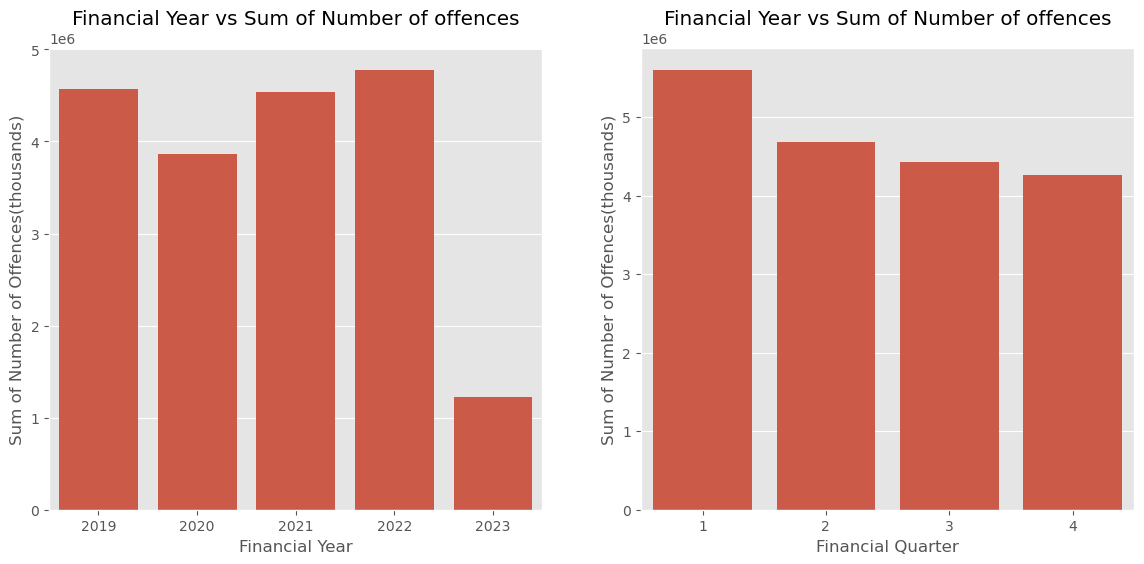

In [ ]:
# Set the figure size for plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Barplot of Financial year vs number of offences
sns.barplot(data=trends_1,  x='Financial_Year', y='sum(Number_of_Offences)',
                                                                                    ax=ax[0]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Year',
                                                                                    ylabel='Sum of Number of Offences(thousands)')

# Plot Barplot of Financial quarter vs number of offences
sns.barplot(data=trends_2,  x='Financial_Quarter', y='sum(Number_of_Offences)',
                                                                                    ax=ax[1]).set(title='Financial Year vs Sum of Number of offences',
                                                                                    xlabel='Financial Quarter',
                                                                                    ylabel='Sum of Number of Offences(thousands)')

# Show plot
plt.show()

## Model Modeling

### **Machine Learning**
- Offense Classification:
    - Can we accurately classify offenses into different groups based on their characteristics?

- The Machine Algorithm used was Decision Tree classifier and Rainforest Classifier as they can be used to make multiclass predictions

In [ ]:
# Features variable X_a and _X_b
X_a = offence_final.select('Financial_Year', 'Financial_Quarter', 'Number_of_Offences' ).toPandas()
X_b = offence_final.select('Offence_Code','Force_Name' ).toPandas()
# target variable
y = offence_final.select('New_ONS_offence_group').toPandas()

NameError: name 'offence_final' is not defined

In [ ]:
# Label encoding for Y
encoder = {
    'Sexual offences': 0,
    'Miscellaneous crimes against society': 1,
    'Violence against the person':  2,
    'Criminal damage and arson': 3,
    'Theft offences': 4,
    'Possession of weapons offences':5,
    'Drug offences': 6,
    'Robbery': 7,
    'Public order offences': 8
}

# Encode values into y
y = y.replace(encoder)

NameError: name 'y' is not defined

In [ ]:
# Initialize one hot encoder
ord = OrdinalEncoder()
X_b_ohe = ord.fit_transform(X_b)

# Features vairable
X = pd.concat([X_a, X_b_ohe], axis=1)

In [ ]:
# Split into train/test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# Create Instance
tree = DecisionTreeClassifier(max_depth=10, random_state=42)

# Fit to training data
tree.fit(X_train, y_train)

# Evaluate model
y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'The model made using Decision Tree Classifier has an accuracy of : {accuracy*100}%')

In [ ]:
# Further evalaution to check for overfitting
y_train_pred = tree.predict(X_train)
accuracy_sc = accuracy_score(y_train, y_train_pred)

print(f'The model made using Decision Tree Classifier has an accuracy of : {accuracy_sc*100}%')
print('This shows that our model is not overfitting on the training data')

In [ ]:
# save model
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(tree)